## Import modules

In [1]:
import math
import random
import numpy as np
import pandas as pd

from pylab import rcParams
from scipy.io import loadmat

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.ensemble import IsolationForest

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay

# Make datasets

- Ref

https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py

- 이상치 탐지를 위해 다수의 정상 데이터와, 소수의 이상치를 생성합니다.

In [2]:
rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(1000, 2)
X_normal1 = np.r_[X + 2, X - 2]
X_normal1 = pd.DataFrame(X_normal1, columns=['x1', 'x2'])
# Generate some regular novel observations
X = 0.3 * rng.randn(200, 2)
X_normal2 = np.r_[X + 2, X - 2]
X_normal2 = pd.DataFrame(X_normal2, columns=['x1', 'x2'])
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(50, 2))  # 이상치 개수 조절
X_outliers = pd.DataFrame(X_outliers, columns=['x1', 'x2'])

In [3]:
# Putting them together
X = pd.concat([X_normal1, X_normal2, X_outliers], axis=0, ignore_index=True)

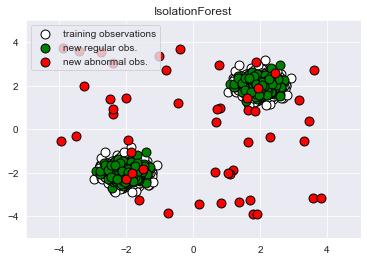

In [4]:
plt.title("IsolationForest")
plt.rcParams['figure.figsize'] = [10, 10]
p1 = plt.scatter(X_normal1.x1, X_normal1.x2, c='white', s=20*4, edgecolor='k', label='training observations')
p2 = plt.scatter(X_normal2.x1, X_normal2.x2, c='green', s=20*4, edgecolor='k', label='new regular obs.')
p3 = plt.scatter(X_outliers.x1, X_outliers.x2, c='red', s=20*4, edgecolor='k', label='new abnormal obs.')

plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))

plt.legend(loc='best')

plt.show()

- 데이터셋을 보면 다음과 같이 하얀색의 train 정상 데이터, 초록색의 새롭게 들어갈 정상 데이터, 마지막으로 빨간색의 이상치 데이터가 있습니다.

In [5]:
# Function to produce a heatmap of the scores
pts = np.linspace(-5, 5, 250)
space = np.array(np.meshgrid(pts, pts)).reshape((2, -1)).T
space_index = pd.MultiIndex.from_arrays([space[:, 0], space[:, 1]])


def plot_space(Z, space_index, X):
    df = pd.DataFrame({"z": Z}, index=space_index)
    df = df.unstack()
    df = df[df.columns.values[::-1]]
    plt.imshow(df, extent=[-5, 5, -5, 5], cmap='hot_r')
    plt.scatter(x=X['x1'], y=X['x2'], alpha=.15, c='navy')

# Isolation Forest

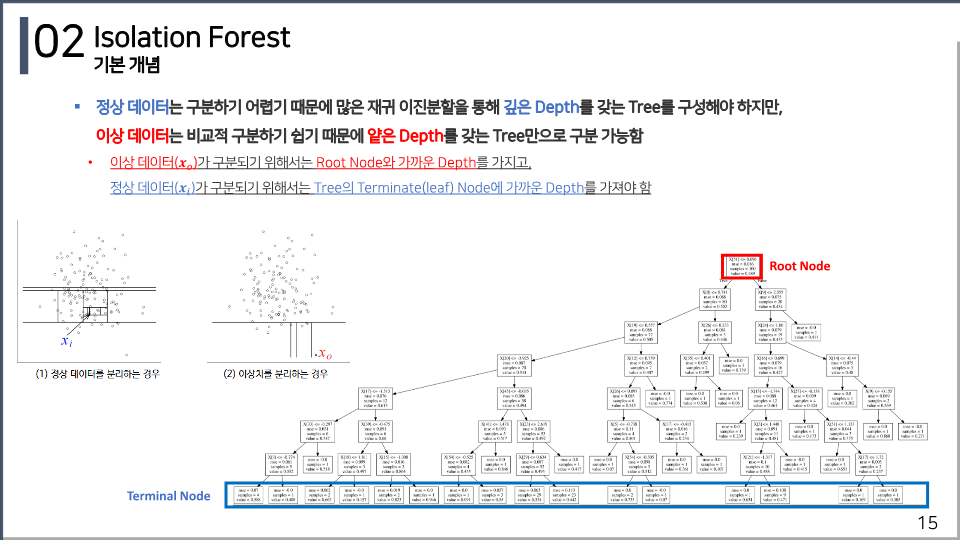

## Hyperparameter (n_estimators, max_samples, contamination, max_features)

- 본 순서에서는 sklearn에서 제공하는 IsolationForest 라이브러리를 사용하여 파라미터 변화에 따른 모델의 변화를 보여주고자 합니다.
- 아래는 파라미터에 대한 설명입니다.

    n_estimators: int, default=100
     - 앙상블에 활용할 분류기(iTree)의 수
         - 많을 수록 좋은 성능을 기대할 수 있지만, 많은 학습 수행 시간이 소요

    max_samples: “auto”, int or float, default=”auto”
     - 분류기(iTree)를 학습하기 위해 데이터셋에서 추출할 샘플의 수
     - 직접 개수를 설정하거나, 데이터셋에서 비율을 설정할 수 있음
         - 'auto'는 min(256, n_samples)에서 선택

    contamination: ‘auto’ or float, default=’auto’
     - 데이터셋에서 이상치의 비율, 이상치로 판단하기 위한 score의 threshold를 정의
         - 'auto'는 논문의 값을 따르고, float의 값은 (0, 0.5] 사이에 존재해야함

    max_features:int or float, default=1.0
     - 각 분류기(iTree)를 학습할 때 사용할 feature의 개수

### n_estimator (5, 10, 20, 50, 100, 200, 250, 500, 1000)

In [6]:
n_estimators_list = [5, 10, 20, 50, 100, 200, 250, 500, 1000]  # default:100

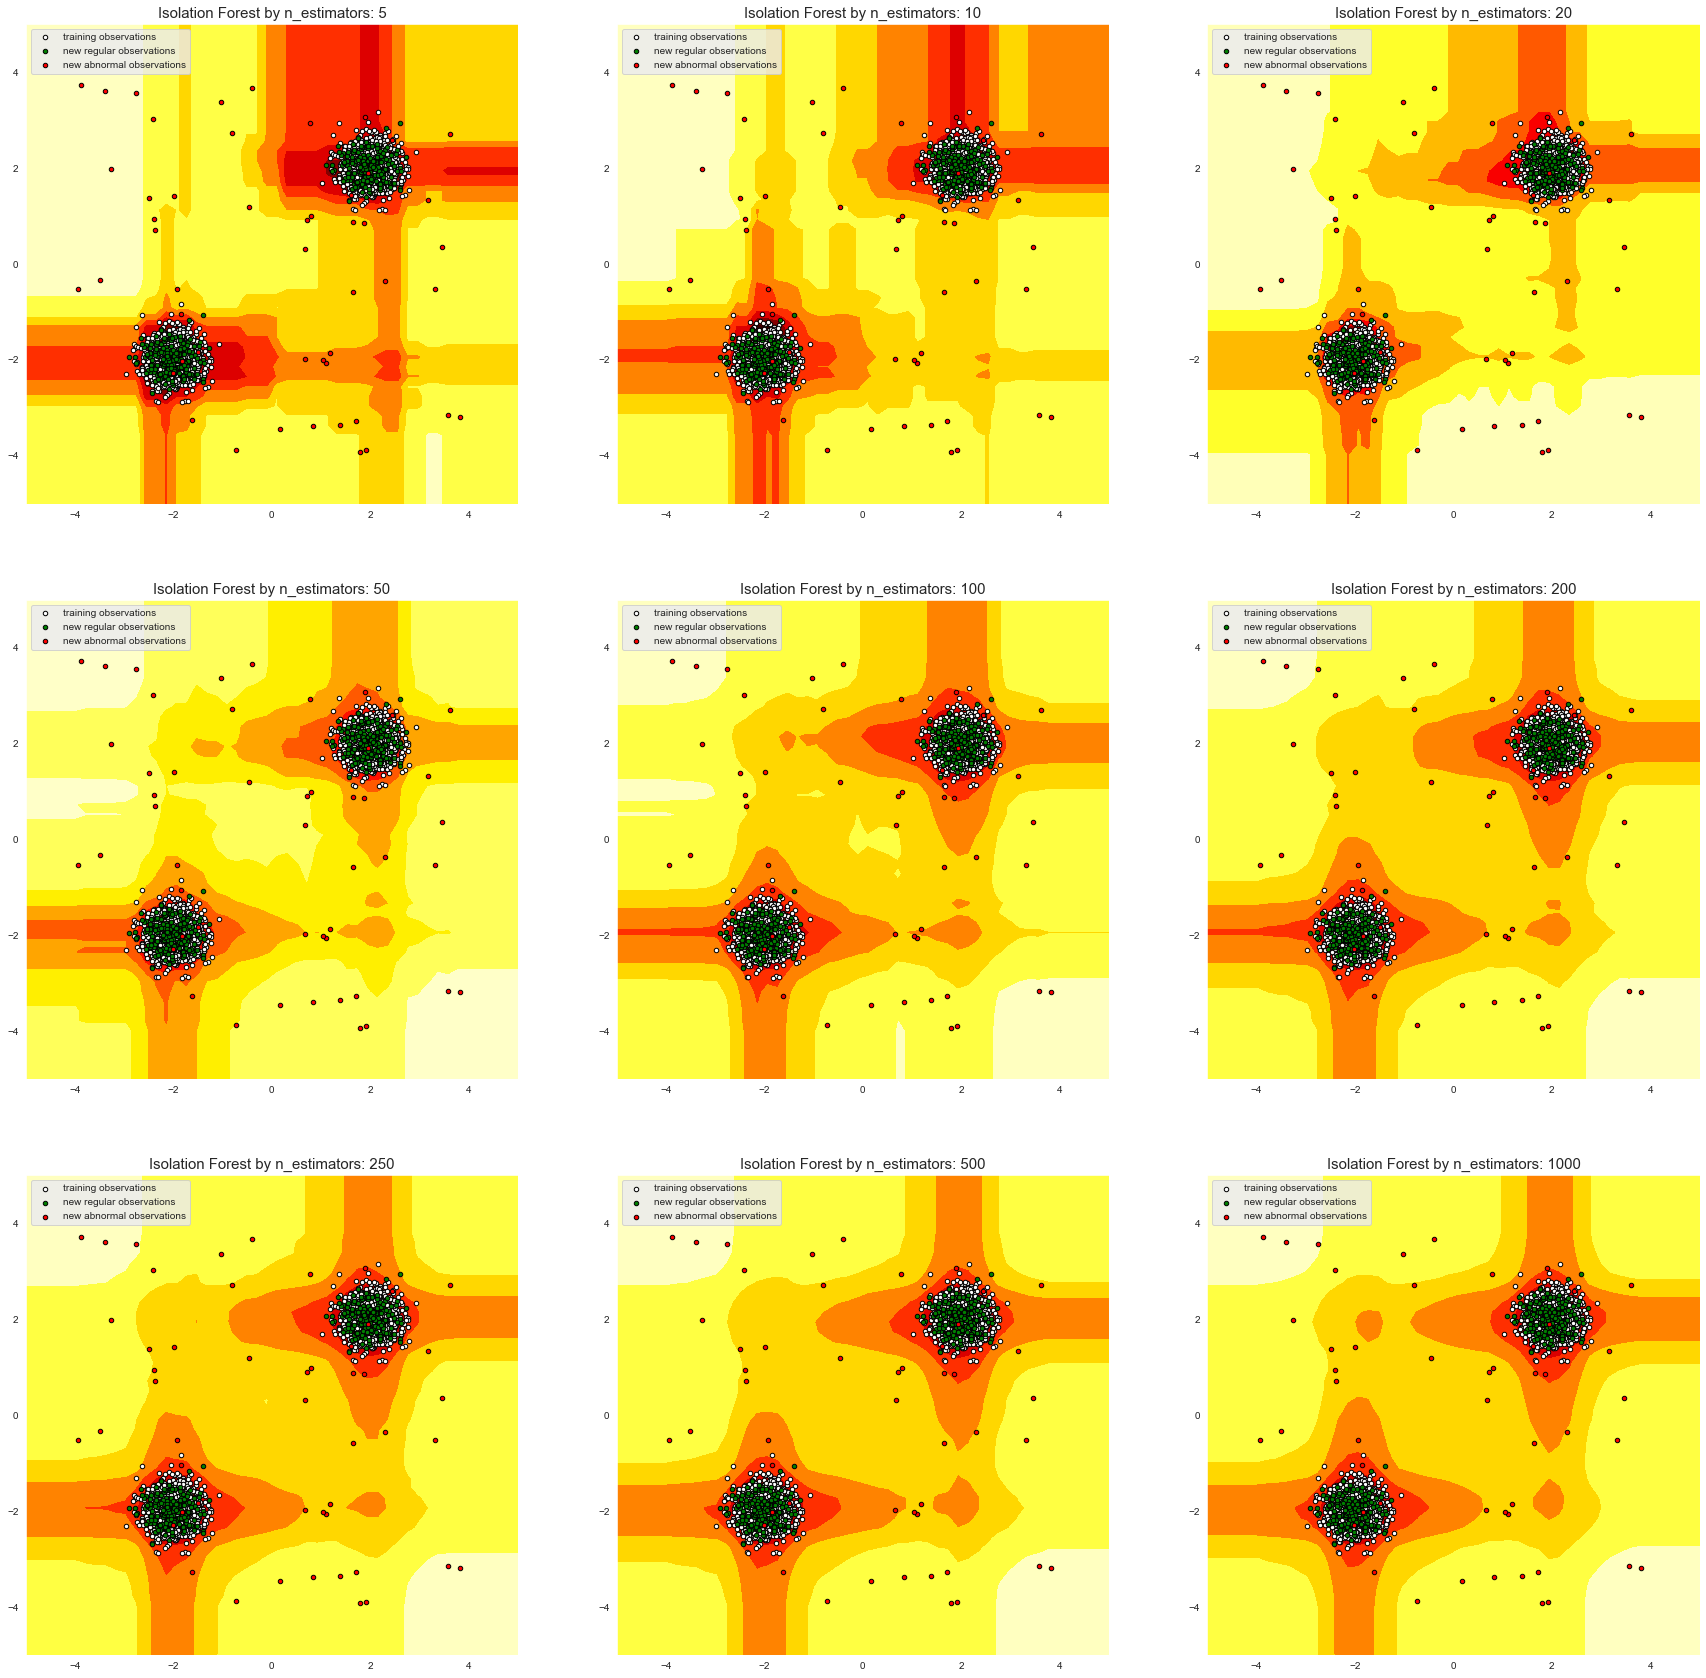

In [7]:
plt.rcParams['figure.figsize'] = [30, 30]

for i, n_estimator in enumerate(n_estimators_list):
    iforest = IsolationForest(n_estimators=n_estimator, random_state=42)
    iforest.fit(X)

    # plot the line, the samples, and the nearest vectors to the plane
    xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
    Z = iforest.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.subplot(3, 3, i+1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.hot_r)

    b1 = plt.scatter(X_normal1.x1, X_normal1.x2, c="white", s=20, edgecolor="k")
    b2 = plt.scatter(X_normal2.x1, X_normal2.x2, c="green", s=20, edgecolor="k")
    c = plt.scatter(X_outliers.x1, X_outliers.x2, c="red", s=20, edgecolor="k")

    plt.axis("tight")
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend([b1, b2, c],
               ["training observations", "new regular observations", "new abnormal observations"],
               loc="upper left")

    plt.title(f"Isolation Forest by n_estimators: {n_estimator}", fontsize=15)

plt.show()

- 사용되는 추정기의 개수에 따른 변화를 보면 다음과 같습니다.

- 시각화 결과, 추정기의 개수가 증가할수록 이상치 점수 밀도의 형태에 대해서 조금 더 세밀한 모습을 확인할 수 있고,

- 개수가 커질수록 정상데이터가 존재하지 않는 대각선 부분 (좌상단 - 우하단)의 부분의 이상치 점수 값이 더 높아지는 것을 확인할 수 있습니다.

#### Real data AUROC 비교

- 실제 데이터셋에 대한 비교 실험을 진행해보겠습니다.

- 데이터셋은 2차원 이상의 이상치 탐지 알고리듬을 벤치마킹하기 위한 가장 일반적인 데이터 세트 중 하나인 "위성" 데이터 세트로,
    원래 다중 클래스 분류를 위해 설계되었지만 일반적으로 가장 덜 일반적인 클래스를 함께 병합하고 "이상치" 또는 "이상치"로 레이블을 지정하여 이상치 탐지에 적합합니다.

In [8]:
sat = loadmat("satellite.mat")
X_features = sat["X"]
y_label = sat["y"]

# y값은 -1 또는 1
y_label = np.where(y_label == 1, -1, 0)
y_label = np.where(y_label == 0, 1, -1)

print("Dataset dimensions: (%d, %d)" % X_features.shape)
print("Percent anomalies: %.2f%%" % (100*y_label.mean()))

Dataset dimensions: (6435, 36)
Percent anomalies: 36.72%


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.3, random_state=42)

In [10]:
params = {"n_estimators": n_estimators_list}

# model define
clf = IsolationForest(random_state=42)

aurocsc = make_scorer(roc_auc_score)

# model train with gridsearchCV
grid_model_clf = GridSearchCV(clf, param_grid=params, cv=5, scoring=aurocsc, refit=True, return_train_score=True)
grid_model_clf.fit(X_train, y_train)

# print results
result = pd.DataFrame(grid_model_clf.cv_results_)

best_model_clf = grid_model_clf.best_estimator_

In [11]:
print("CV score")
result[["params"] + ["split" + str(i) + "_test_score" for i in range(5)] + ["std_test_score", "mean_test_score"]]

CV score


,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_test_score,mean_test_score
0,{'n_estimators': 5},0.709708,0.645427,0.725625,0.740081,0.687421,0.033106,0.701653
1,{'n_estimators': 10},0.712291,0.684967,0.707600,0.686175,0.697114,0.011011,0.697630
2,{'n_estimators': 20},0.696691,0.697891,0.717506,0.714035,0.697030,0.009170,0.704631
3,{'n_estimators': 50},0.701808,0.700315,0.701471,0.691177,0.670822,0.011815,0.693119
4,{'n_estimators': 100},0.701262,0.701122,0.709033,0.715516,0.685950,0.009893,0.702577
5,{'n_estimators': 200},0.701510,0.710638,0.711544,0.718087,0.692772,0.008824,0.706910
6,{'n_estimators': 250},0.707273,0.713376,0.710716,0.727840,0.699594,0.009278,0.711760
7,{'n_estimators': 500},0.699126,0.708057,0.709061,0.713225,0.688556,0.008817,0.703605
8,{'n_estimators': 1000},0.695449,0.708057,0.704866,0.707133,0.688598,0.007574,0.700821


- n_estimator의 개수 변화에 따른 실험 결과, AUROC의 값을 지표로 CV=5를 설정해 비교했을 때의 모습입니다.
- 흥미로운 점은 AUROC 값의 변화가 추정기 개수의 증감에 따른 패턴이 보이지 않았고, 성능이 비슷비슷한 모습을 확인할 수 있습니다.

In [12]:
print("Isolation Forest by n_estimator")
print("Best Parameter : " + str(grid_model_clf.best_params_))

# predict
pred = best_model_clf.predict(X_test)
# cross table
tab = pd.crosstab(y_test.ravel(), pred, rownames=["real"], colnames=["pred"])
print(tab)
print("Acc : " + str((tab.iloc[0, 0] + tab.iloc[1, 1]) / len(X_test)))

Isolation Forest by n_estimator
Best Parameter : {'n_estimators': 250}
pred   -1     1
real           
-1    251   355
 1     54  1271
Acc : 0.7881926462972553


- 최종적으로 n_estimator외의 모든 파라미터를 고정하고 실험한 결과, n_estimator=250일 때 결과가 가장 좋게 나왔습니다.
- 이를 통해, 추정기의 개수가 많다고 해서 무조건적인 성능의 증가 되지는 않는다는 것을 확인할 수 있었습니다.

### max_samples (np.sqrt(len(X)), 50, 100, 150, 200, 'auto', 500, 750, 1000)

In [13]:
max_samples_list = [np.int(np.sqrt(len(X))), 50, 100, 150, 200, 'auto', 500, 750, 1000] # default: 'auto': min(256, n_samples)

C:\Users\YongGon\AppData\Local\Temp/ipykernel_14480/1537380347.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_samples_list = [np.int(np.sqrt(len(X))), 50, 100, 150, 200, 'auto', 500, 750, 1000] # default: 'auto': min(256, n_samples)


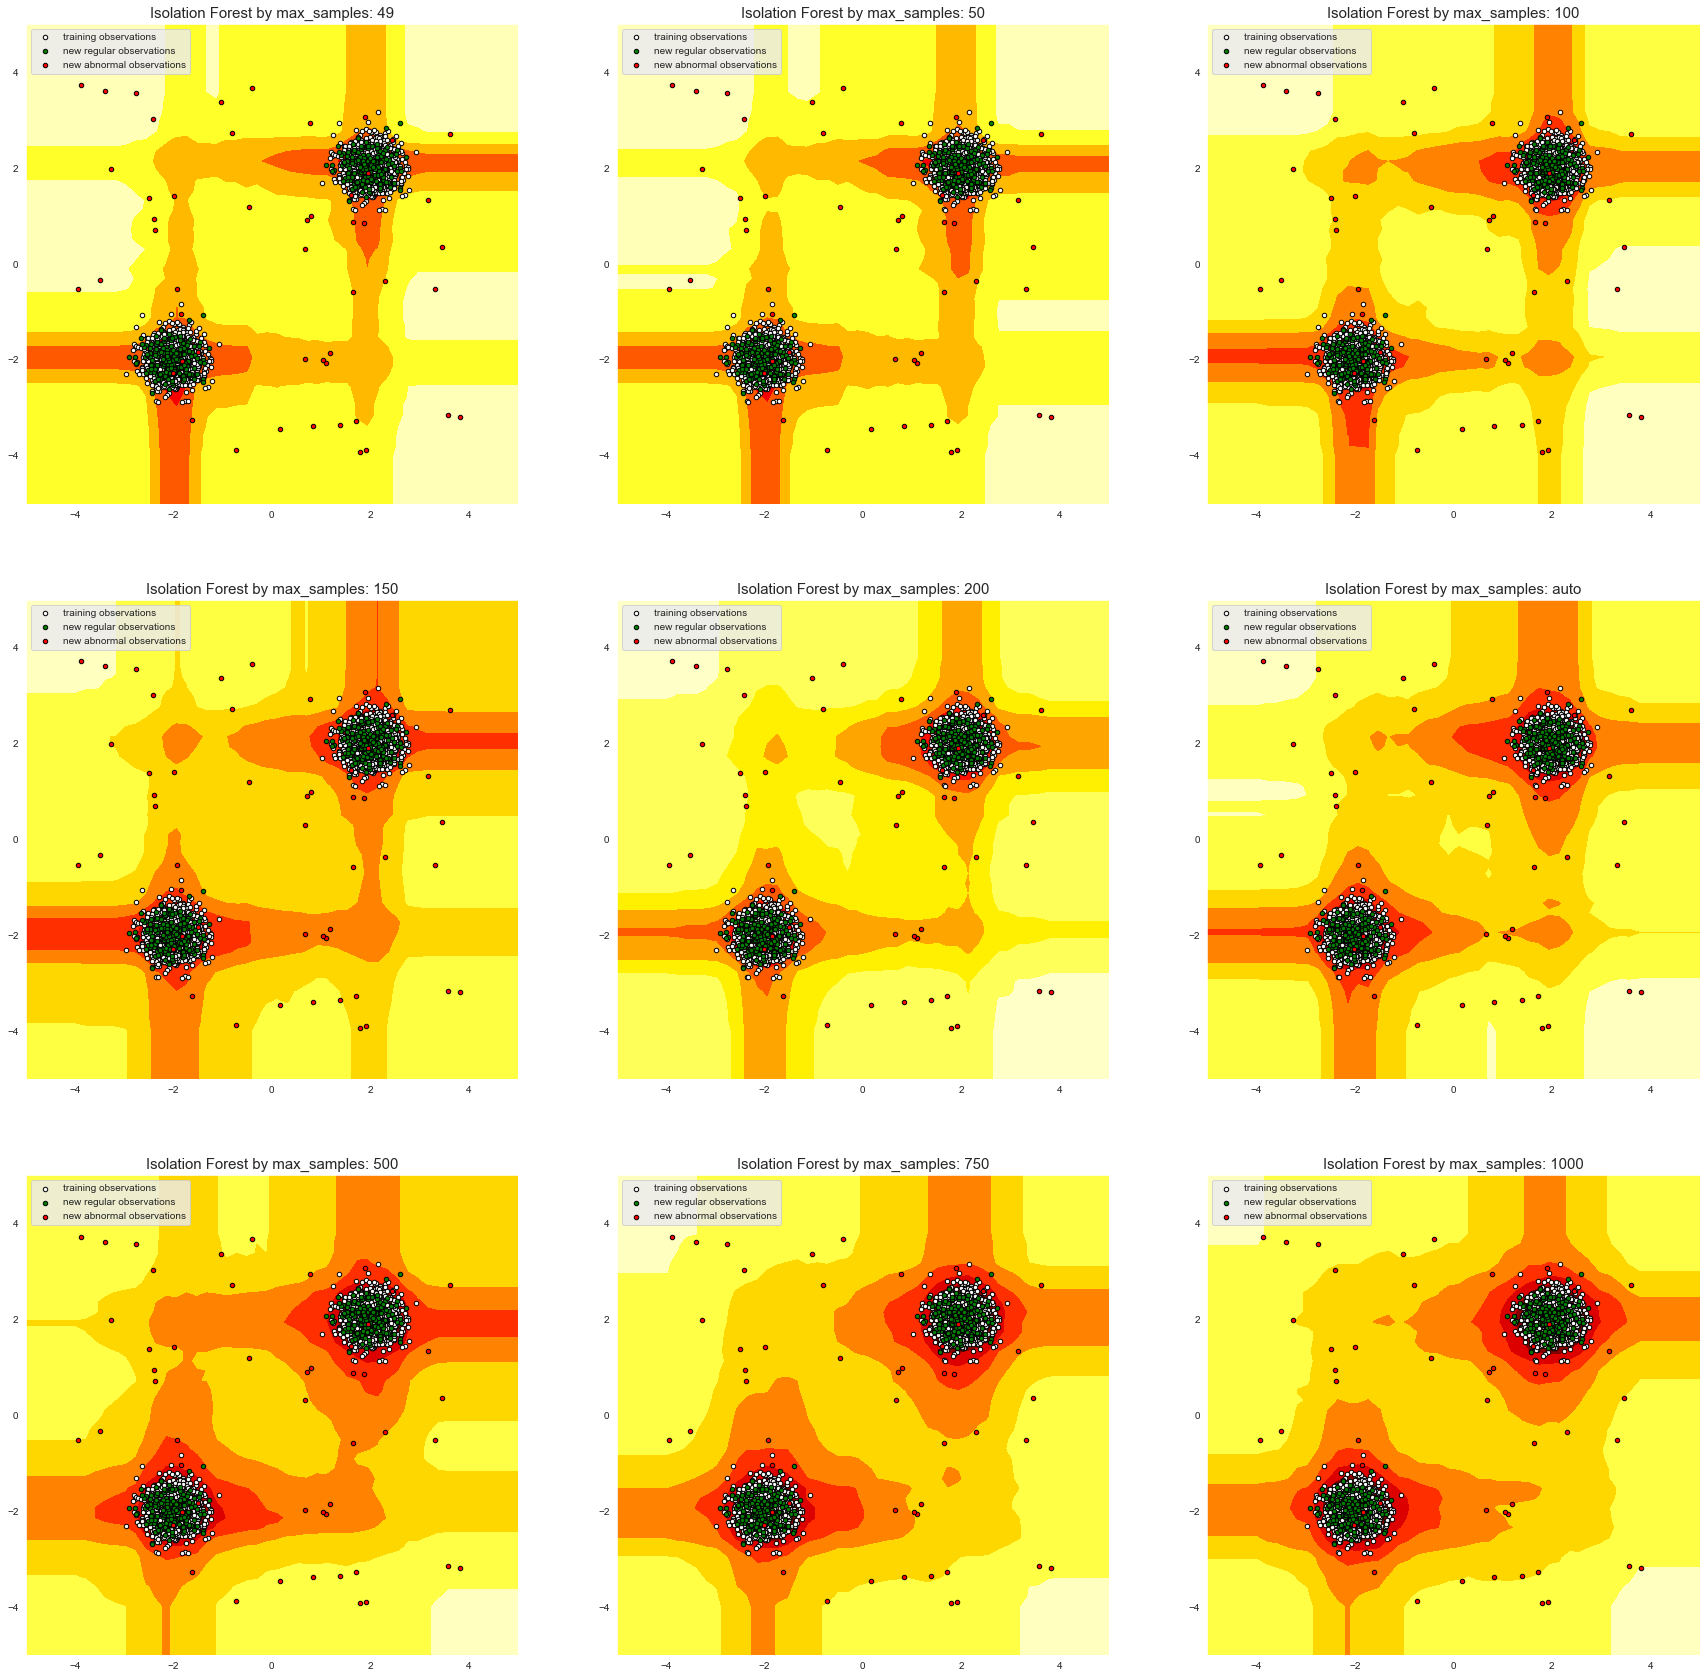

In [14]:
plt.rcParams['figure.figsize'] = [30, 30]

for i, max_sample in enumerate(max_samples_list):
    iforest = IsolationForest(max_samples=max_sample, random_state=42)
    iforest.fit(X)

    # plot the line, the samples, and the nearest vectors to the plane
    xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
    Z = iforest.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.subplot(3, 3, i+1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.hot_r)

    b1 = plt.scatter(X_normal1.x1, X_normal1.x2, c="white", s=20, edgecolor="k")
    b2 = plt.scatter(X_normal2.x1, X_normal2.x2, c="green", s=20, edgecolor="k")
    c = plt.scatter(X_outliers.x1, X_outliers.x2, c="red", s=20, edgecolor="k")

    plt.axis("tight")
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend([b1, b2, c],
               ["training observations", "new regular observations", "new abnormal observations"],
               loc="upper left")

    plt.title(f"Isolation Forest by max_samples: {max_sample}", fontsize=15)

plt.show()

- 다음으로 학습시 사용되는 데이터의 개수 변화에 따른 결과를 보면 다음과 같습니다.

- 시각화 결과, 데이터의 개수가 증가할수록 대각선 부분 (좌상단 - 우하단)의 부분 및 내부 사각형의 부분에 있어서 이상치 점수 밀도의 값의 변화가 생김을 확인할 수 있었습니다.

#### Real data AUROC 비교

In [15]:
params = {"max_samples": max_samples_list}

# model define
clf = IsolationForest(random_state=42)

aurocsc = make_scorer(roc_auc_score)

# model train with gridsearchCV
grid_model_clf = GridSearchCV(clf, param_grid=params, cv=5, scoring=aurocsc, refit=True, return_train_score=True)
grid_model_clf.fit(X_train, y_train)

# print results
result = pd.DataFrame(grid_model_clf.cv_results_)

best_model_clf = grid_model_clf.best_estimator_

In [16]:
print("CV score")
result[["params"] + ["split" + str(i) + "_test_score" for i in range(5)] + ["std_test_score", "mean_test_score"]]

CV score


,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_test_score,mean_test_score
0,{'max_samples': 49},0.702901,0.694697,0.689090,0.700961,0.668861,0.012230,0.691302
1,{'max_samples': 50},0.697387,0.684689,0.695741,0.710155,0.673862,0.012283,0.692367
2,{'max_samples': 100},0.721632,0.709947,0.697639,0.720045,0.695840,0.010814,0.709020
3,{'max_samples': 150},0.700914,0.700610,0.702410,0.707721,0.674548,0.011631,0.697241
4,{'max_samples': 200},0.705932,0.705634,0.714083,0.706462,0.691946,0.007158,0.704811
5,{'max_samples': 'auto'},0.701262,0.701122,0.709033,0.715516,0.685950,0.009893,0.702577
6,{'max_samples': 500},0.661914,0.694523,0.694653,0.695731,0.673218,0.013899,0.684008
7,{'max_samples': 750},0.641693,0.658096,0.667690,0.673654,0.646883,0.012064,0.657603
8,{'max_samples': 1000},0.616753,0.640208,0.652482,0.669043,0.635887,0.017409,0.642875


- max_samples 개수 변화에 따른 실험 결과, AUROC의 값을 지표로 CV=5를 설정해 비교했을 때의 모습입니다.
- 흥미로운 점은 AUROC 값의 변화를 살펴보면, 일정 수 이하(500 미만)의 값을 설정한 경우 비슷한 결과를 보이지만, 일정 수 이상의 데이터 개수를 지정하면(500 이상) AUROC 값이 하락되는 모습을 확인할 수 있습니다.

In [17]:
print("Isolation Forest by max_sample")
print("Best Parameter : " + str(grid_model_clf.best_params_))

# predict
pred = best_model_clf.predict(X_test)
# cross table
tab = pd.crosstab(y_test.ravel(), pred, rownames=["real"], colnames=["pred"])
print(tab)
print("Acc : " + str((tab.iloc[0, 0] + tab.iloc[1, 1]) / len(X_test)))

Isolation Forest by max_sample
Best Parameter : {'max_samples': 100}
pred   -1     1
real           
-1    260   346
 1     92  1233
Acc : 0.7731745209735889


- 최종적으로 max_samples외의 모든 파라미터를 고정하고 실험한 결과, max_sample=100일 때 결과가 가장 좋게 나왔습니다.
- 이를 통해, 사용되는 데이터의 개수가 많다고 해서 무조건적인 성능의 증가 되지는 않는다는 것을 확인할 수 있었습니다.
- 또한, Isolation Forest의 특징 가운데 <Sub-sampling: 전수 데이터가 아닌 sampling한 데이터로 모델을 생성 (군집화 이상탐지 방식은 전수데이터를 사용해야 함)>에 대한 부분도 어느정도 설명할 수 있다고 생각했습니다.

### contamination (0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 'auto')

In [18]:
contaminations_list = list(np.round(np.arange(0.1, 0.51, 0.05), 3))
contaminations_list.append('auto')
contaminations_list

[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 'auto']

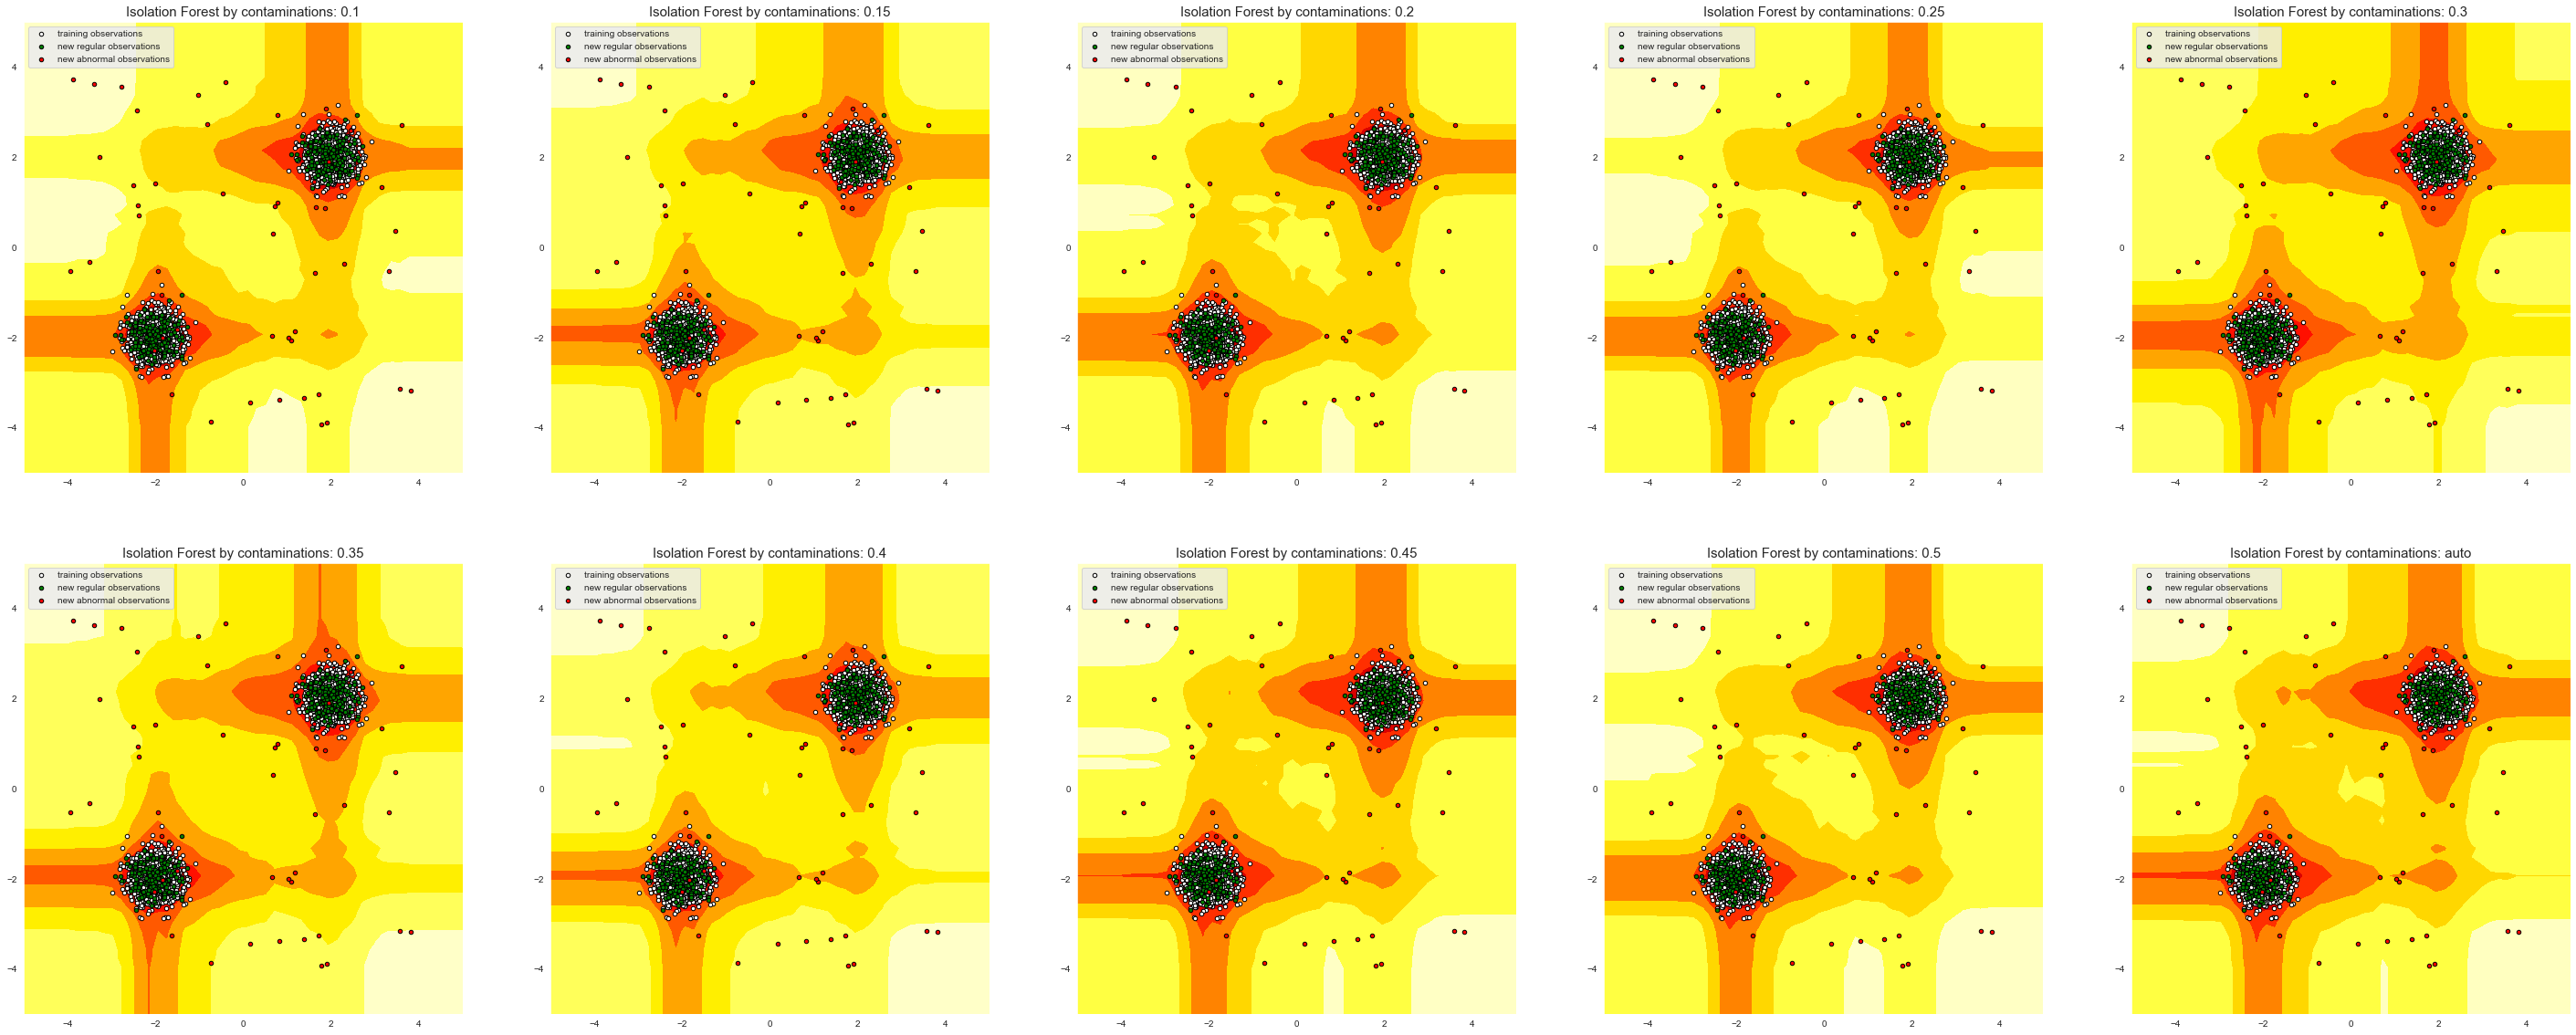

In [19]:
plt.rcParams['figure.figsize'] = [50, 20]

for i, cont in enumerate(contaminations_list):
    iforest = IsolationForest(contamination=cont, random_state=42)
    iforest.fit(X)

    # plot the line, the samples, and the nearest vectors to the plane
    xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
    Z = iforest.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.subplot(2, 5, i+1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.hot_r)

    b1 = plt.scatter(X_normal1.x1, X_normal1.x2, c="white", s=20, edgecolor="k")
    b2 = plt.scatter(X_normal2.x1, X_normal2.x2, c="green", s=20, edgecolor="k")
    c = plt.scatter(X_outliers.x1, X_outliers.x2, c="red", s=20, edgecolor="k")

    plt.axis("tight")
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend([b1, b2, c],
               ["training observations", "new regular observations", "new abnormal observations"],
               loc="upper left")

    plt.title(f"Isolation Forest by contaminations: {cont}", fontsize=15)

plt.show()

- 사용되는 모델의 이상치 비율에 대한 변화에 대해 결과를 보면 다음과 같습니다.
- 시각화 결과, 이상치 비율이 증가할수록 결정 경계를 지나치게 좁게 잡아 정상 데이터를 오분류하는 경우를 확인할 수 있습니다.
- 그래서 일반적으로는, 실제 이상치 비율과 파라미터 설정 비율이 같을 때 합리적인 결정 경계를 그리는 경우가 많습니다.

#### Real data AUROC 비교

In [20]:
params = {"contamination": contaminations_list}

# model define
clf = IsolationForest(random_state=42)

aurocsc = make_scorer(roc_auc_score)

# model train with gridsearchCV
grid_model_clf = GridSearchCV(clf, param_grid=params, cv=5, scoring=aurocsc, refit=True, return_train_score=True)
grid_model_clf.fit(X_train, y_train)

# print results
result = pd.DataFrame(grid_model_clf.cv_results_)

best_model_clf = grid_model_clf.best_estimator_

In [21]:
print("CV score")
result[["params"] + ["split" + str(i) + "_test_score" for i in range(5)] + ["std_test_score", "mean_test_score"]]

CV score


,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_test_score,mean_test_score
0,{'contamination': 0.1},0.627583,0.633609,0.650715,0.661721,0.663622,0.014575,0.647450
1,{'contamination': 0.15},0.688692,0.700492,0.703099,0.706294,0.681650,0.009337,0.696046
2,{'contamination': 0.2},0.709807,0.720448,0.719385,0.721665,0.694887,0.010093,0.713239
3,{'contamination': 0.25},0.718253,0.717630,0.715580,0.707527,0.694649,0.008906,0.710728
4,{'contamination': 0.3},0.713831,0.714674,0.707637,0.699871,0.685152,0.010916,0.704233
5,{'contamination': 0.35},0.709360,0.716722,0.688020,0.674387,0.677308,0.017016,0.693159
6,{'contamination': 0.4},0.697834,0.706496,0.661781,0.662540,0.674464,0.018361,0.680623
7,{'contamination': 0.45},0.673887,0.684666,0.642880,0.655723,0.656577,0.014742,0.662747
8,{'contamination': 0.5},0.659181,0.659606,0.620669,0.625739,0.647205,0.016435,0.642480
9,{'contamination': 'auto'},0.701262,0.701122,0.709033,0.715516,0.685950,0.009893,0.702577


- contamination의 비율 변화에 따른 실험 결과, AUROC의 값을 지표로 CV=5를 설정해 비교했을 때의 모습입니다.
- 흥미로운 점은 AUROC 값의 변화가 지나치게 낮은 비율(0.1)과 지나치게 높은 비율(0.4, 0.45, 0.5)의 경우 성능이 하락되는 모습을 확인할 수 있었고, 적당한 비율의 경우 다른 경우들과 비슷한 성능을 보임을 확인할 수 있었습니다.

In [22]:
print("Isolation Forest by contamination")
print("Best Parameter : " + str(grid_model_clf.best_params_))

# predict
pred = best_model_clf.predict(X_test)
# cross table
tab = pd.crosstab(y_test.ravel(), pred, rownames=["real"], colnames=["pred"])
print(tab)
print("Acc : " + str((tab.iloc[0, 0] + tab.iloc[1, 1]) / len(X_test)))

Isolation Forest by contamination
Best Parameter : {'contamination': 0.2}
pred   -1     1
real           
-1    269   337
 1     75  1250
Acc : 0.7866390471258415


- 최종적으로 contamination외의 모든 파라미터를 고정하고 실험한 결과, contamination=0.2일 때 결과가 가장 좋게 나왔습니다.
- 이를 통해, 이상치 비율을 의도적으로 늘리는 것에 대해서 무조건적인 성능의 증가 되지는 않는다는 것을 확인할 수 있었고,
- 이 부분은 실제 데이터에 대해한 이해도가 높아야지 비율을 추리해서 설정하기 때문에 사용하는 데이터셋에 대한 도메인적인 지식이 필요한 부분이라고 생각했고, 모델을 사용함에 있어 중요한 파라미터 중 하나라고 생각했습니다.

### max_features (1, 2)

In [23]:
max_features_list = [1, 2]  # default: 1.0

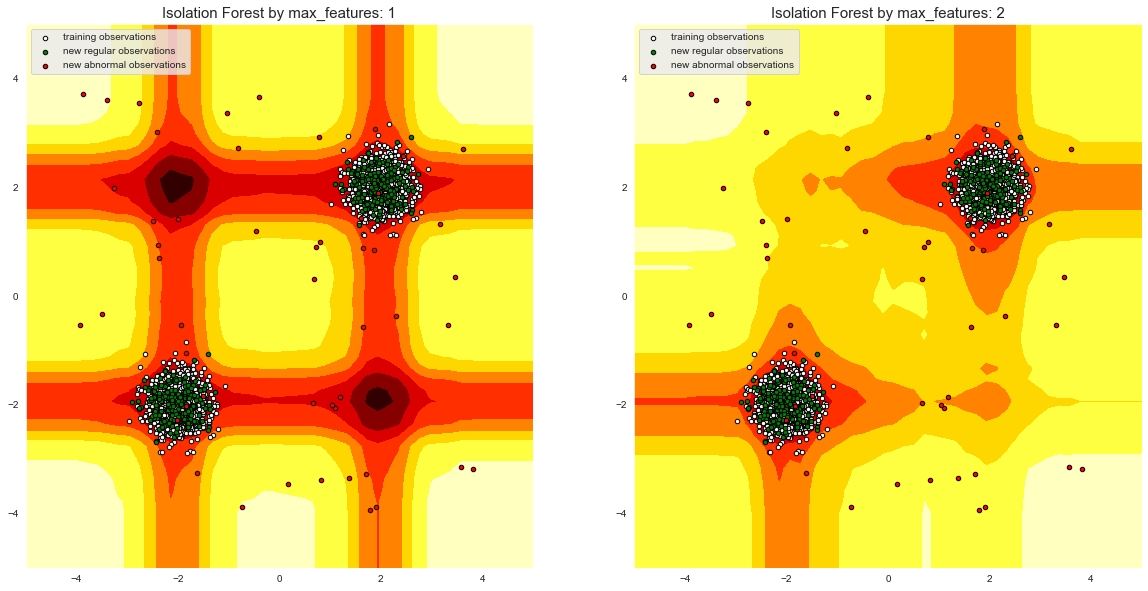

In [24]:
plt.rcParams['figure.figsize'] = [20, 10]

for i, max_feature in enumerate(max_features_list):
    iforest = IsolationForest(max_features=max_feature, random_state=42)
    iforest.fit(X)

    # plot the line, the samples, and the nearest vectors to the plane
    xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
    Z = iforest.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.subplot(1, 2, i+1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.hot_r)

    b1 = plt.scatter(X_normal1.x1, X_normal1.x2, c="white", s=20, edgecolor="k")
    b2 = plt.scatter(X_normal2.x1, X_normal2.x2, c="green", s=20, edgecolor="k")
    c = plt.scatter(X_outliers.x1, X_outliers.x2, c="red", s=20, edgecolor="k")

    plt.axis("tight")
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend([b1, b2, c],
               ["training observations", "new regular observations",
                   "new abnormal observations"],
               loc="upper left")

    plt.title(f"Isolation Forest by max_features: {max_feature}", fontsize=15)

plt.show()

- 사용되는 feature 개수에 따른 변화를 보면 다음과 같습니다. 우선 생성 데이터셋에 대한 실험으로 변수는 x1, x2로 두 개 밖에 없는 점 양해바랍니다.
- 시각화 결과, feature의 개수를 많이 사용할 수록 대각선 부분 (좌상단 - 우하단)의 부분의 이상치 점수 값이 크게 변화함을 확인할 수 있습니다.

#### Real data AUROC 비교

In [25]:
params = {"max_features": max_features_list}

# model define
clf = IsolationForest(random_state=42)

aurocsc = make_scorer(roc_auc_score)

# model train with gridsearchCV
grid_model_clf = GridSearchCV(clf, param_grid=params, cv=5, scoring=aurocsc, refit=True, return_train_score=True)
grid_model_clf.fit(X_train, y_train)

# print results
result = pd.DataFrame(grid_model_clf.cv_results_)

best_model_clf = grid_model_clf.best_estimator_

In [26]:
print("CV score")
result[["params"] + ["split" + str(i) + "_test_score" for i in range(5)] + ["std_test_score", "mean_test_score"]]

CV score


,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_test_score,mean_test_score
0,{'max_features': 1},0.709261,0.721156,0.691490,0.677654,0.704679,0.014989,0.700848
1,{'max_features': 2},0.714577,0.700432,0.704922,0.691374,0.695798,0.007986,0.701420


- max_features의 개수 변화에 따른 실험 결과, AUROC의 값을 지표로 CV=5를 설정해 비교했을 때의 모습입니다.
- 흥미로운 점은 위의 그림과 데이터는 다르지만 극적인 변화가 있을 것으로 기대했습니다.
- 하지만, AUROC 값의 변화가 max_features 수의 변화에도 크게 다르지 않고, 성능이 비슷한 모습을 확인할 수 있습니다.

In [27]:
print("Isolation Forest by max_feature")
print("Best Parameter : " + str(grid_model_clf.best_params_))

# predict
pred = best_model_clf.predict(X_test)
# cross table
tab = pd.crosstab(y_test.ravel(), pred, rownames=["real"], colnames=["pred"])
print(tab)
print("Acc : " + str((tab.iloc[0, 0] + tab.iloc[1, 1]) / len(X_test)))

Isolation Forest by max_feature
Best Parameter : {'max_features': 2}
pred   -1     1
real           
-1    260   346
 1    104  1221
Acc : 0.7669601242879337


- 최종적으로 max_features외의 모든 파라미터를 고정하고 실험한 결과, max_features=2일 때 결과가 가장 좋게 나왔습니다.
- 이를 통해, max_features의 개수 비교에 대해서는 유의미한 성능의 확인이 되지는 않았지만, 그래도 사용하는 iTree 구성에 있어서 feature의 개수가 늘어나면 좋은 결과가 나올 것이라는 생각이 듭니다.

### AUROC & ACC 최종 비교 (Hyperparameters) (With Real dataset)

In [28]:
params = {"n_estimators": n_estimators_list, "max_samples": max_samples_list,
          "contamination": contaminations_list, "max_features": [1, 2, 3, 5, 10]}  # 생성 데이터와는 다르게 변수 5개까지 늘려봄

# model define
clf = IsolationForest(random_state=42)

aurocsc = make_scorer(roc_auc_score)

# model train with gridsearchCV
grid_model_clf = GridSearchCV(clf, param_grid=params, cv=5, scoring=aurocsc, refit=True, return_train_score=True)
grid_model_clf.fit(X_train, y_train)

# print results
result = pd.DataFrame(grid_model_clf.cv_results_)

best_model_clf = grid_model_clf.best_estimator_

In [29]:
print("CV score")
result[["params"] + ["split" + str(i) + "_test_score" for i in range(5)] + ["std_test_score", "mean_test_score"]]

CV score


,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_test_score,mean_test_score
0,"{'contamination': 0.1, 'max_features': 1, 'max...",0.512818,0.562154,0.563675,0.579702,0.531307,0.024285,0.549931
1,"{'contamination': 0.1, 'max_features': 1, 'max...",0.613076,0.629413,0.611334,0.635872,0.618770,0.009494,0.621693
2,"{'contamination': 0.1, 'max_features': 1, 'max...",0.630217,0.631028,0.638903,0.638163,0.645805,0.005727,0.636823
3,"{'contamination': 0.1, 'max_features': 1, 'max...",0.620479,0.635539,0.639731,0.632741,0.650889,0.009872,0.635876
4,"{'contamination': 0.1, 'max_features': 1, 'max...",0.649642,0.641509,0.638903,0.634362,0.650932,0.006334,0.643070
...,...,...,...,...,...,...,...,...
4045,"{'contamination': 'auto', 'max_features': 10, ...",0.656151,0.675512,0.662611,0.685028,0.652795,0.012120,0.666419
4046,"{'contamination': 'auto', 'max_features': 10, ...",0.645121,0.653585,0.655905,0.679746,0.652010,0.011797,0.657273
4047,"{'contamination': 'auto', 'max_features': 10, ...",0.643531,0.649881,0.657589,0.680556,0.651184,0.012807,0.656548
4048,"{'contamination': 'auto', 'max_features': 10, ...",0.633545,0.646335,0.654222,0.672704,0.646925,0.012838,0.650746


- 최종적으로 '위성' 데이터셋에 대해 모든 하이퍼파라미터에 대한 gridsearchCV를 진행한 결과,
- 다음과 같이 4050개 case의 실험을 진행했고 최적의 파라미터를 찾는 과정을 진행했습니다.

In [56]:
print("Isolation Forest by gridsearchCV")
print("Best Parameter : " + str(grid_model_clf.best_params_))

# predict
pred = best_model_clf.predict(X_test)
# cross table
tab = pd.crosstab(y_test.ravel(), pred, rownames=["real"], colnames=["pred"])
print(tab)
print("Acc : " + str((tab.iloc[0, 0] + tab.iloc[1, 1]) / len(X_test)))

Isolation Forest by gridsearchCV
Best Parameter : {'contamination': 0.25, 'max_features': 3, 'max_samples': 750, 'n_estimators': 20}
pred   -1     1
real           
-1    321   285
 1    124  1201
Acc : 0.7881926462972553


- 결과, Best Parameter : {'contamination': 0.25, 'max_features': 3, 'max_samples': 750, 'n_estimators': 20}일 때 AUROC의 값이 가장 좋게 나왔고,
- 이 모델을 사용해 testset을 분류한 결과, 78.82%의 정확도를 달성할 수 있었습니다.

## Isolation Forest 알고리즘별 설명

- 다음부터는 Isolation Forest를 구성하는 알고리즘들에 대해 각각 설명을 하고, 이를 구현하는 과정입니다.

### Algorithm 2 (iTree)

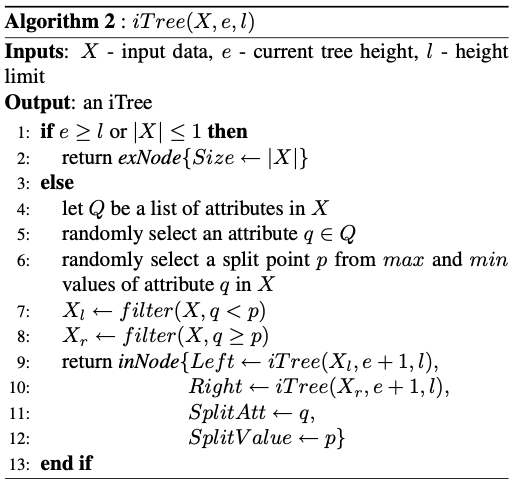

    1. 샘플링된 X′가 Isolation이 된다면 external node로 반환
    4. X′의 변수를 Q라는 list에 저장
        5. 랜덤하게 변수를 선택
        6. 랜덤하게 split할 p를 해당 변수의 최대값과 최소값에서 선택
        7. p값 보다 작은 데이터는 Xl(left)로 할당
        8. p값 보다 큰 데이터는 Xl(right)로 할당
    9. 재귀적으로 데이터 point가 립될 때 까지 iTree를 반복하게 되며, 분기되는 history들을 저장

- Selecting a feature(column) of the data

In [32]:
def select_feature(data):
    return random.choice(data.columns)

- Select a random value within the range

In [33]:
def select_value(data, feat):
    mini = data[feat].min()
    maxi = data[feat].max()
    return (maxi-mini)*np.random.random()+mini

- Split data

In [34]:
def split_data(data, split_column, split_value):
    data_below = data[data[split_column] <= split_value]
    data_above = data[data[split_column] > split_value]

    return data_below, data_above

In [35]:
def classify_data(data):

    label_column = data.values[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]

    return classification

In [36]:
def isolation_tree(data, counter=0, max_depth=50, random_subspace=False):

    # End Loop if max depth or isolated
    if (counter == max_depth) or data.shape[0] <= 1:
        classification = classify_data(data)
        return classification

    else:
        # Counter
        counter += 1

        # Select feature
        split_column = select_feature(data)

        # Select value
        split_value = select_value(data, split_column)
        # Split data
        data_below, data_above = split_data(data, split_column, split_value)

        # instantiate sub-tree
        question = "{} <= {}".format(split_column, split_value)
        sub_tree = {question: []}

        # Recursive part
        below_answer = isolation_tree(data_below, counter, max_depth=max_depth)
        above_answer = isolation_tree(data_above, counter, max_depth=max_depth)

        if below_answer == above_answer:
            sub_tree = below_answer
        else:
            sub_tree[question].append(below_answer)
            sub_tree[question].append(above_answer)

        return sub_tree

### Algorithm 1 (iForest)

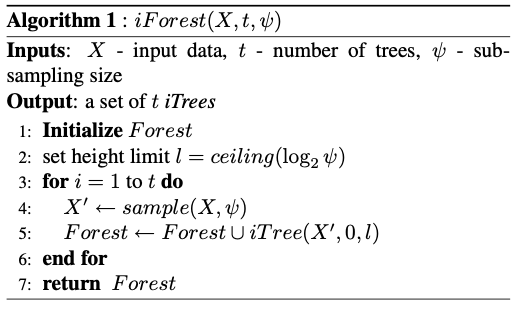

    1. Forest을 저장할 빈 객체 생성
    2. for loop
        3. 데이터(X) 샘플링
        4. 샘플링된 X′로 만들어진 iTree를 Forest 객체에 추가
    5. 종료
    6. Forest 객체 반환

In [37]:
def isolation_forest(df, n_trees=5, max_depth=5, subspace=256):
    forest = []

    for i in range(n_trees):
        # Sample the subspace
        if subspace <= 1:
            df = df.sample(frac=subspace)
        else:
            df = df.sample(subspace)

        # Fit tree
        tree = isolation_tree(df, max_depth=max_depth)

        # Save tree to forest
        forest.append(tree)

    return forest

### Algorithm 3 (PathLength)

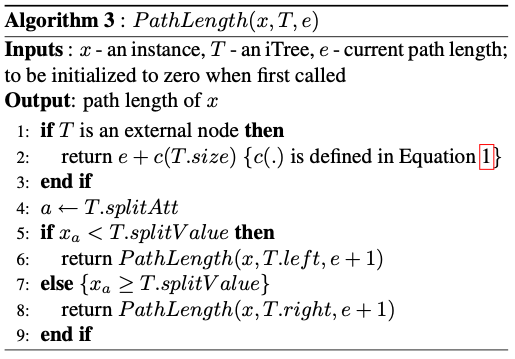

    1. 데이터의 수가 1보다 크고 external node 이거나 hlim보다 클때,
        2. 분기하지 못한 것에 대한 평균 height(c(n))를 더해 줌
    4. split하려는 변수를 a로 정의
    5. 변수 a의 값을 가져와 split point보다 작으면 누적된 현재 pathLength를 반환
    6. 변수 a의 값을 가져와 split point보다 크면 누적된 현재 pathLength를 반환

In [38]:
def pathLength(example, iTree, path=0, trace=False):

    path = path+1
    question = list(iTree.keys())[0]

    feature_name, comparison_operator, value = question.split()

    # ask question
    if example[feature_name].values <= float(value):
        answer = iTree[question][0]
    else:
        answer = iTree[question][1]

    # base case
    if not isinstance(answer, dict):
        return path

    # recursive part
    else:
        residual_tree = answer
        return pathLength(example, residual_tree, path=path)

    return path

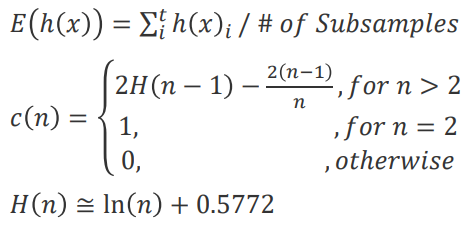

• ℎ(𝑥): 샘플 데이터 𝒙까지의 Path length


• 𝐸(ℎ(𝑥)): 샘플 데이터 𝑥가 각 iTree에서 구분될 때, 사용된 Path lengths의 평균


• 𝑐(𝑛): ℎ(𝑥)를 normalize하기 위한 값으로, iTree의 평균 Path length $(average~path~length~of~unsuccessful~search~in~BST~(Binary~Search~Tree)[B. R. Presis, 1999])$


• 𝑛: the number of sample data


• 𝐻(𝑛): Harmonic number (0.5772: Euler-Mascheroni Constant)

- 위의 Algorithm 3를 통해 모든 데이터 포인트의 path length를 구할 수 있다.
- 이를 t 개의 iTree에 적용한 후 average 하면 모든 데이터 포인트에 대해 average path length 인 $E(h(x))$를 얻을 수 있다.
- 이를 이용해 최종적으로 Anomaly score 인 $s(x,n)$을 얻는다.

In [39]:
def harmonic_number(n, constant):
    return np.log(n)+constant

In [40]:
def c_factor(n, constant):
    if n > 2:
        return 2 * harmonic_number(n-1, constant) - 2*(n-1)/n
    if n == 2:
        return 1
    return 0

In [41]:
def evaluate_instance(instance, forest):
    paths = []
    for tree in forest:
        paths.append(pathLength(instance, tree))
    return paths

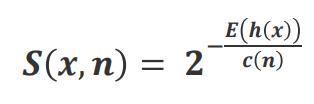

In [42]:
def anomaly_score(data_point, forest, n, constant):
    # Mean depth for an instance
    E = np.mean(evaluate_instance(data_point, forest))
    c = c_factor(n, constant)
    return 2**-(E/c)

#### Evaluate the whole dataset

In [43]:
iForest = isolation_forest(X, n_trees=20, max_depth=100, subspace=256)

- 임의의 isolation forest 분류기를 생성 및 위의 생성 데이터셋 X에 대해 분할과정을 진행한다.

In [44]:
an= []
for i in range(X.shape[0]):
    an.append(anomaly_score(X.iloc[[i]],iForest,256, np.euler_gamma))

- 해당 분류기에 대해 모든 데이터셋을 넣고 이상치 점수를 계산한다.


- 이때, average path length 계산을 위해서 학습에 사용된 sampel_size $(n)$는 위 분류기의 설정처럼 동일하게 기본 개수인 256개로 설정했다.

In [45]:
def instance_depth_plot(instance,outlier,forest):
    plt.rcParams['figure.figsize'] = [20, 10]
    
    bars1 = evaluate_instance(outlier,forest)
    bars2 = evaluate_instance(instance,forest)

    # width of the bars
    barWidth = 0.3

    # The x position of bars
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    
    # Create cyan bars
    plt.bar(r2, bars2, width = barWidth, capsize=7, label='Normal Sample')

    # Create blue bars
    plt.bar(r1, bars1, width = barWidth,  capsize=7, label='Outlier')
    
    # general layout

    plt.ylabel('Tree Depth')
    plt.xlabel('Trees')
    plt.legend()

    plt.show()

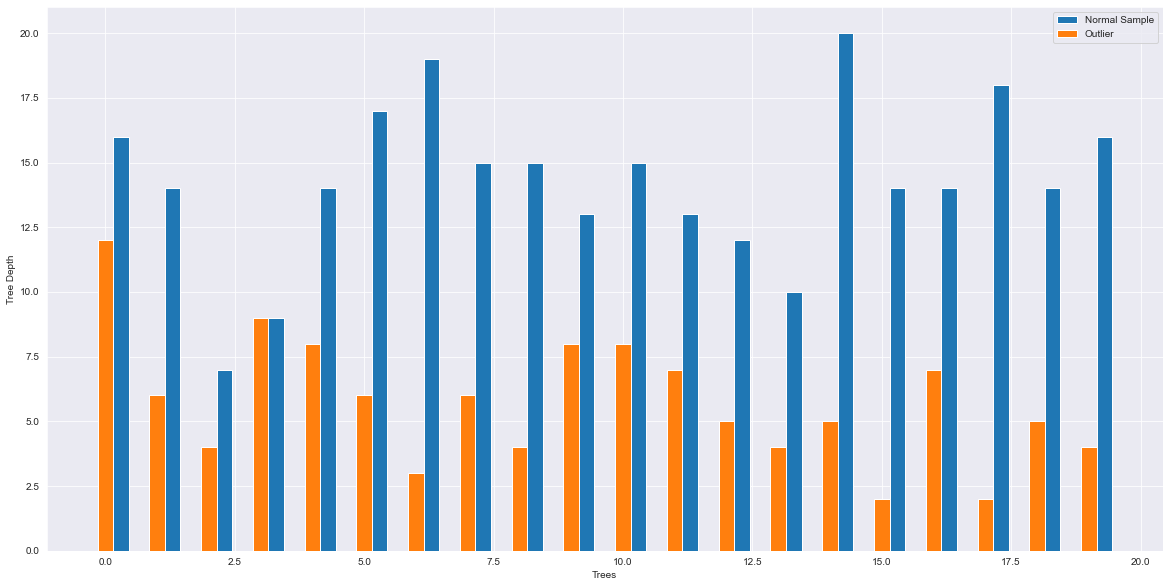

In [108]:
instance_depth_plot(X.head(1),X.tail(1),iForest)

- 1개 데이터에 대해 학습을 위해 사용되었던 각 tree들 (20개)에 대해 실험을 한 모습입니다.




- 처음 X.tail(1)은 데이터셋에서 뒤에서 1개를 선택하는 것이고, X.head(1)은 위에서 1개를 선택하는 것입니다.



    - 생성 데이터셋의 경우, 정상 데이터가 위쪽으로, 이상 데이터가 아래쪽이 되도록 데이터셋을 concat했음을 생각하고 plotting 결과를 보면 될 것 같습니다.





- 실험결과, 각 tree에서 정상 데이터의 tree depth가 이상 데이터보다 훨씬 큰 것을 확인할 수 있습니다.

In [109]:
outlier  = evaluate_instance(X.tail(1),iForest)
normal  = evaluate_instance(X.head(1),iForest)

In [110]:
np.mean(outlier)

5.75

In [111]:
np.mean(normal)

14.25

- tree 깊이의 평균값에 대한 비교 결과, 정상 데이터의 경우 depth 값이 크고 이상 데이터의 경우 보다 작은 depth 값이 나오는 것을 확인할 수 있습니다.

- 이는 정상 데이터는 분류를 위해서 많은 수의 가지가 필요하고, 이상 데이터는 적은 가지가 필요함을 확인할 수 있습니다.

In [94]:
iForest = isolation_forest(X,n_trees=20, max_depth=100, subspace=256)

In [112]:
print('Anomaly score for outlier:',anomaly_score(X.tail(1),iForest,256, np.euler_gamma))

Anomaly score for outlier: 0.6777091054172627


In [97]:
print('Anomaly score for normal:',anomaly_score(X.head(1),iForest,256, np.euler_gamma))

Anomaly score for normal: 0.38131270251231675


- 이상치 점수에 대한 비교 결과, [0,1] 범위 내에서 보면 정상 데이터셋에 대한 경우 점수가 확연히 낮게 나옴을 확인할 수 있고, 이상 데이터의 경우 값이 크게 나타남을 확인할 수 있습니다.

## Average path length - Euler constant

    - 이 파트에서는 Average path length 계산에 있어서
    왜 𝐻(𝑛): Harmonic number (0.5772: Euler-Mascheroni Constant)을 사용하는지에 대해 궁금증을 해결하려고 합니다.
    
    - 𝐻(𝑛): Harmonic number (0.5772: Euler-Mascheroni Constant)에 대해서는 'average path length of unsuccessful search in BST (Binary Search Tree)[B. R. Presis, 1999]'의 내용을 사용한 것으로, 자료구조에 대한 내용이 필요하다.
    
    - unsuccessful search란에 대해 알려면 우선 해쉬 테이블에 대해 알아야 합니다.
        - 해싱: 임의의 길이의 값을 해시함수(Hash Function)를 사용하여 고정된 크기의 값으로 변환하는 작업
        - 해시 테이블: 해시함수를 사용하여 변환한 값을 색인(index)으로 삼아 키(key)와 데이터(value)를 저장하는 자료구조
        - successful search: 찾고자 하는 데이터가 해시 테이블에 있는 경우
        - unsuccessful search: 찾고자 하는 데이터가 해시 테이블에 없는 경우
    
    - 따라서, BST를 이용해 자료를 분할하고 탐색하는 과정에서, 알고싶은 데이터에 대해 해시 테이블을 구성하지 못한 상황에서
    '평균적으로 어느정도의 path length를 가지겠구나'라는 기대값을 얘기하는 것입니다.
    
    해당 과정을 유도하는 과정은 다음 과정을 거쳐서 결론적으로 오일러 상수가 나오는 이유가 설명됩니다.
Ref)
https://en.wikipedia.org/wiki/Harmonic_number

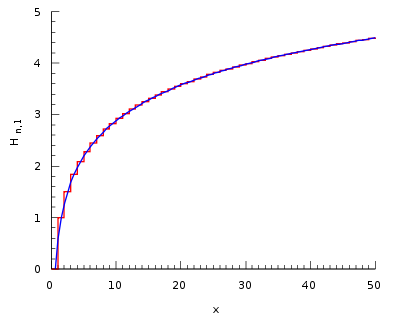

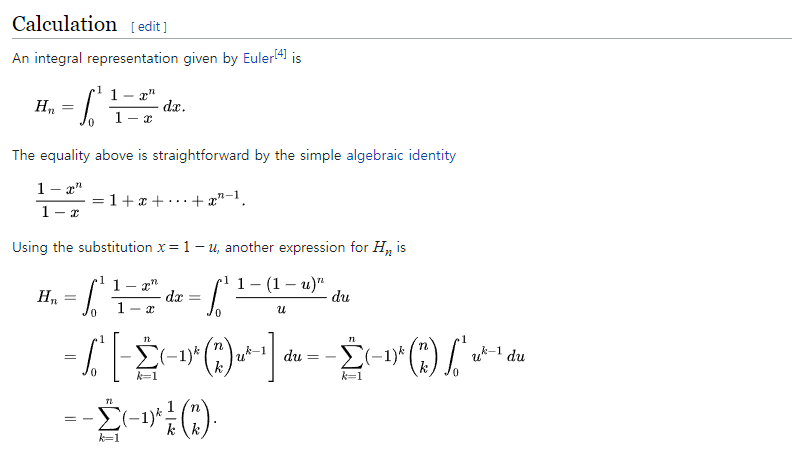

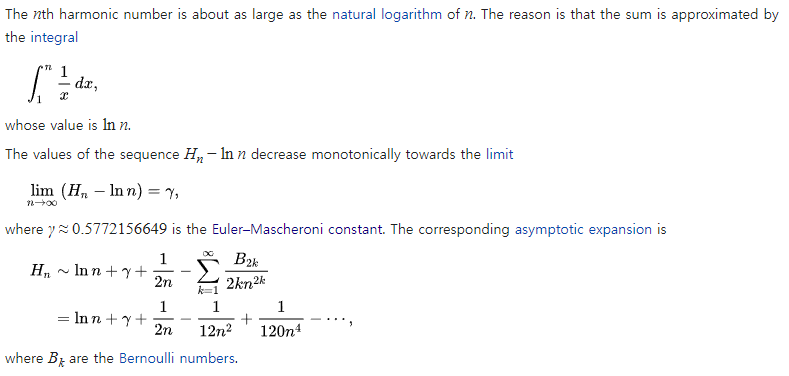

    - 사실 수학적 계산에의해 도출된 값을 사용하는 것이므로, 해당 수식을 변경하거나 다른 값으로 사용하게 되면 결론적으로는 이상치 스코어 변형에 있어서 기존의 [0,1] 사이의 값이 아닌 더 넓은 범위의 값이 나오게 될 가능성도 존재하게 됩니다.

    - 하지만 개인적인 의문으로, 오일러 상수 이외의 다른 값을 넣어보면 어떻게 변화되는지를 가볍게 알아보고자 합니다.
        - 여기서 나는 오일러 상수를 지운 버전과 오일러 상수와 관련있는 Gamma function과 관련된 다양한 수학적 상수들을 적용해보고 출력되는 결과값들에 대한 비교를 보여주고자 합니다.

- 차례대로 [Zero, Euler_constant, Bernstein_constant, Apéry's constant, Sierpiński constant, Gauss's constant, Landau's constants]

In [53]:
constants_dict = {'zero':0, 'Euler_constant':np.euler_gamma, 'Bernstein_constant':0.2801694990, 'Apéry constant':1.2020569032, 'Sierpiński constant':2.5849817596, 'Gauss constant':0.8346268, 'Landau constants':0.5432589653}

In [54]:
iForest = isolation_forest(X, n_trees=100, max_depth=100, subspace=256)

In [113]:
for i, constant in constants_dict.items():
    print(f'Anomaly score for outlier with: {i}')
    print(anomaly_score(X.tail(1), iForest, 256, constant))
    print(f'Anomaly score for normal with: {i}')
    print(anomaly_score(X.head(1), iForest, 256, constant))
    print('\n')

Anomaly score for outlier with: zero
0.6450399294373197
Anomaly score for normal with: zero
0.3373695795995949


Anomaly score for outlier with: Euler_constant
0.6777091054172627
Anomaly score for normal with: Euler_constant
0.38131270251231675


Anomaly score for outlier with: Bernstein_constant
0.6616714679526894
Anomaly score for normal with: Bernstein_constant
0.3593396144499707


Anomaly score for outlier with: Apéry constant
0.7069885361463043
Anomaly score for normal with: Apéry constant
0.4234523754315913


Anomaly score for outlier with: Sierpiński constant
0.7561701287615084
Anomaly score for normal with: Sierpiński constant
0.5002504631145861


Anomaly score for outlier with: Gauss constant
0.6904425005751865
Anomaly score for normal with: Gauss constant
0.3993153634986354


Anomaly score for outlier with: Landau constants
0.6759519405155894
Anomaly score for normal with: Landau constants
0.3788672189482939




- 실험 결과, 이상치 점수를 나타냄에 있어 제곱 부분의 분모 부분의 값이 변화됨에 따라 자연스럽게 이상치 점수의 범위가 변동이 될 것입니다.


- 우선 모든 케이스에 대해 정상 데이터의 이상치 점수가 이상 데이터의 이상치 점수보다 낮게 나왔음을 확인할 수 있었습니다.

- 하지만, 공부를 할 수록 증명에 의해 계산된 오일러 상수를 사용하는 것이 맞다라고 생각하게 되었는데 왜나하면 불완전한 이진 탐색 트리 구조에서 결국 평균적으로 계산되는 경로 길이는 결국 조화수의 값을 따라가는 것을 확인했기 때문입니다. (위의 설명 그림 참고)


- 따라서, 오일러 상수를 이용해서 계산하는 것이 이상치 점수 계산 부분에 있어 $E(h(n))$을 normalize하는 역할을 잘 해주는 것으로 생각되기 때문에 오일러 상수를 사용하는 것에 대한 궁금증을 해결할 수 있었습니다.

# Referrence

https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
https://donghwa-kim.github.io/iforest.html
https://github.com/cmougan/IsolationForest/blob/master/IsolationForest.ipynb

# EOD